In [407]:
import torch
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

In [408]:
import json

# Load the label mapping
with open('./content/squeezenet-labels.json') as f:
    label_mapping = json.load(f)


In [409]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    
    # Clip the perturbed image values to ensure they stay within the valid range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image

In [410]:
model = models.squeezenet1_0(pretrained=True)

In [411]:
input_image = "./content/dog.png"  # Provide the path to your input image
image = Image.open(input_image).convert("RGB")  # Convert image to RGB format
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

processed_image = preprocess(image).unsqueeze(0)

In [412]:
def show_image_label(image, label):
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)
    plt.show()

def print_top_predictions(output, label_mapping, top_k=5):
    probabilities = torch.nn.functional.softmax(output, dim=1)[0]
    top5_prob, top5_catid = torch.topk(probabilities, top_k)

    print("Top 5 Predictions:")
    for i in range(top5_prob.size(0)):
        label = label_mapping[str(top5_catid[i].item())]
        percentage = top5_prob[i].item() * 100
        print(f'{label}: {percentage:.2f}%')

def show_image_and_predictions(image, output, label_mapping, top_k=5):
    # Check if the image has 4 dimensions and squeeze if necessary
    if image.dim() == 4:
        image = image.squeeze(0)
    
    # Show the image
    plt.imshow(image.permute(1, 2, 0).cpu().detach().numpy())
    plt.axis('off')
    plt.show()
    
    # Get the top predictions
    probabilities = torch.nn.functional.softmax(output, dim=1)[0]
    top5_prob, top5_catid = torch.topk(probabilities, top_k)
    
    # Print the top predictions
    print_top_predictions(output, label_mapping, top_k)

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)  # Reverse the normalization
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))



In [413]:
processed_image.requires_grad = True

In [414]:
output = model(processed_image)
show_image_and_predictions(processed_image, output, label_mapping)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

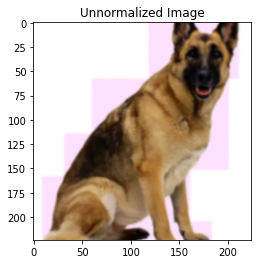

In [ ]:
processed_image_copy = processed_image.clone().detach()
unnormalized_processed_image = unorm(processed_image_copy.squeeze())
plt.imshow(unnormalized_processed_image.permute(1, 2, 0).cpu().numpy())
plt.title('Unnormalized Image')
plt.show()



In [ ]:
true_label = torch.tensor([235])  # The true label for a dog class (235 for german shepheard)
loss = torch.nn.CrossEntropyLoss()(output, true_label)

In [ ]:
model.zero_grad()
loss.backward()
data_grad = processed_image.grad.data

In [ ]:
epsilon = 0.025  # Adjust this value to control the strength of the attack
perturbed_image = fgsm_attack(processed_image, epsilon, data_grad)

In [ ]:
output = model(perturbed_image)
show_image_and_predictions(perturbed_image, output, label_mapping)
new_predicted_label = torch.argmax(output, 1).item()


Top 5 Predictions:
sarong: 12.17%
conch: 3.84%
balloon: 3.80%
torch: 3.50%
kimono: 2.73%


In [ ]:
image_np = np.transpose(processed_image.squeeze().detach().numpy(), (1, 2, 0))
perturbed_image_np = np.transpose(perturbed_image.squeeze().detach().numpy(), (1, 2, 0))